In [28]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [29]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data_new.csv", index_col="date")

In [30]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [31]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [32]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [33]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    #print(cols)
#     # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Data Transformation

In [34]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [35]:
#getting the last 3 days' data
historic_data = np.array([])
for day in values[-3:]:
    #historic_data = np.concatenate((values[-3], values[-2], values[-1]), axis=None)
    historic_data = np.concatenate((historic_data, day), axis=None)
historic_data = np.append (historic_data, historic_data[0]) #add a dummy for prediction

In [36]:
#historic_data

In [37]:
#convert data to become supervised 
look_back = 3 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)

In [38]:
#look_back = 5
number_of_variables = 8
#keeping first varible in first period
reframed.drop(reframed.columns[-1 * number_of_variables + 1:], axis=1, inplace=True) 
reframed.drop(reframed.columns[look_back*number_of_variables:-1], axis=1, inplace=True)

In [39]:
reframed = reframed.append(dict(zip(reframed.columns, historic_data)), ignore_index=True)
#reframed

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pred = scaler.fit_transform(reframed)

In [41]:
scaled_pred.shape

(7929, 25)

In [42]:
pred_para = scaled_pred[-1][:-1]
pred_para

array([0.91908985, 0.27766392, 0.20090296, 0.48750462, 0.58589085,
       0.43241157, 0.44119747, 0.87848608, 0.92966685, 0.27459015,
       0.19977429, 0.46088247, 0.59575571, 0.41575062, 0.44036592,
       0.8451906 , 0.92327189, 0.2817623 , 0.20880363, 0.45984428,
       0.59633417, 0.41411882, 0.44392966, 0.84661354])

In [43]:
pred_para = pred_para.reshape(1,1,pred_para.shape[0])

In [44]:
pred_para

array([[[0.91908985, 0.27766392, 0.20090296, 0.48750462, 0.58589085,
         0.43241157, 0.44119747, 0.87848608, 0.92966685, 0.27459015,
         0.19977429, 0.46088247, 0.59575571, 0.41575062, 0.44036592,
         0.8451906 , 0.92327189, 0.2817623 , 0.20880363, 0.45984428,
         0.59633417, 0.41411882, 0.44392966, 0.84661354]]])

# Final Input Data Example

# Model 2

In [166]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')

# Callbacks
from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('market_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]


multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
                                verbose=1, shuffle=False, callbacks = callbacks_list)

Train on 5549 samples, validate on 2379 samples
Epoch 1/40
5549/5549 [==============================] - 2s 308us/step - loss: 0.0549 - val_loss: 0.1538

Epoch 00001: val_loss improved from inf to 0.15378, saving model to market_lstm_model_weights.hdf5
Epoch 2/40
5549/5549 [==============================] - 0s 49us/step - loss: 0.1974 - val_loss: 0.1300

Epoch 00002: val_loss improved from 0.15378 to 0.13005, saving model to market_lstm_model_weights.hdf5
Epoch 3/40
5549/5549 [==============================] - 0s 47us/step - loss: 0.1172 - val_loss: 0.0917

Epoch 00003: val_loss improved from 0.13005 to 0.09174, saving model to market_lstm_model_weights.hdf5
Epoch 4/40
5549/5549 [==============================] - 0s 49us/step - loss: 0.0760 - val_loss: 0.0675

Epoch 00004: val_loss improved from 0.09174 to 0.06752, saving model to market_lstm_model_weights.hdf5
Epoch 5/40
5549/5549 [==============================] - 0s 48us/step - loss: 0.0581 - val_loss: 0.0577

Epoch 00005: val_loss i

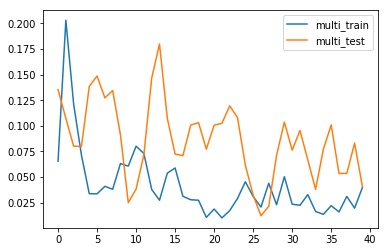

In [144]:
#plot result 
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

# Load Market and predict

In [45]:
pred_para.shape

(1, 1, 24)

In [46]:
#plot prediction
from keras.models import load_model

multi_model = load_model("market_lstm_model_weights.hdf5")
#yhat = multi_model.predict(test_X)
yhat = multi_model.predict(pred_para)
# pyplot.plot(yhat, label='predict')
# pyplot.plot(test_y, label='true')
# pyplot.legend()
# pyplot.show()

In [47]:
yhat

array([[0.84946907]], dtype=float32)

In [48]:
pred_para.shape

(1, 1, 24)

In [49]:
pred_para = pred_para.reshape((1,24))
pred_para.shape

(1, 24)

In [50]:
pred_para

array([[0.91908985, 0.27766392, 0.20090296, 0.48750462, 0.58589085,
        0.43241157, 0.44119747, 0.87848608, 0.92966685, 0.27459015,
        0.19977429, 0.46088247, 0.59575571, 0.41575062, 0.44036592,
        0.8451906 , 0.92327189, 0.2817623 , 0.20880363, 0.45984428,
        0.59633417, 0.41411882, 0.44392966, 0.84661354]])

In [51]:
pred = concatenate((pred_para[:, :], yhat), axis=1)
pred

array([[0.91908985, 0.27766392, 0.20090296, 0.48750462, 0.58589085,
        0.43241157, 0.44119747, 0.87848608, 0.92966685, 0.27459015,
        0.19977429, 0.46088247, 0.59575571, 0.41575062, 0.44036592,
        0.8451906 , 0.92327189, 0.2817623 , 0.20880363, 0.45984428,
        0.59633417, 0.41411882, 0.44392966, 0.84661354, 0.84946907]])

In [52]:
inv_pred = scaler.inverse_transform(pred)

In [53]:
inv_pred = inv_pred[:,-1]

In [54]:
inv_pred

array([2523.28835074])